In [1]:
import pandas as pd
import numpy as np
import csv

# roc curve and auc on an imbalanced dataset
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Creating Prediction Dataframe and calculating probabilities  

In [2]:
"""
Moving the prediction file
from rapidminer folder to
the import_file_path
"""

# Reading path
import_file_path = 'csv/import_export/rapidminer_prediction/xgboost_pred.csv'

# Export path
export_file_path = 'csv/import_export/probability/xgboost_probability.csv'

In [3]:
"""
Creating the prediction csv file
"""
# CSV file
df_classifier = pd.read_csv(import_file_path)

# Create the ID column by concatenating the values of 'subject_id', 'hadm_id'
df_classifier['subject_&_hadm'] = df_classifier['subject_id'].astype(str) + df_classifier['hadm_id'].astype(str)

# Create column propability of alive (1 for alive 0 for death)
df_classifier['Prediction_of_alive'] = df_classifier['prediction(hospital_expire_flag)'].apply(lambda x: 1 if x == 0 else 0)

# Create column propability of death 1 for death 0 for alive
df_classifier['Prediction_of_death'] = df_classifier['prediction(hospital_expire_flag)'].apply(lambda x: 1 if x == 1 else 0)

# Replace 0 with 1 and 1 with 0 in the 'hospital_expire_flag' column and rename the column
df_classifier['hospital_expire_flag'] = df_classifier['hospital_expire_flag'].replace({0: 1, 1: 0})
df_classifier = df_classifier.rename(columns={'hospital_expire_flag': 'Ground_Truth_Alive'})

# Remove the 'prediction(hospital_expire_flag)' column
df_classifier = df_classifier.drop(columns=['prediction(hospital_expire_flag)'])

In [4]:
"""
Calculate the probability of Alive and Death
"""

# Create a new column 'denominator' that counts for each 'subject_&_hadm'
df_classifier['Denominator'] = df_classifier.groupby('subject_&_hadm').cumcount() + 1

# Create a new column 'numerator' based on the conditions
#df_classifier['Numerator'] = df_classifier.groupby('subject_&_hadm')['Prediction_of_alive'].transform(
    #lambda x: x.cumsum() if x.iloc[0] != 0 else x.cumsum() - 1
#).replace(-1, 0)



# Create the 'Numerator' column
df_classifier['Numerator'] = df_classifier.groupby('subject_&_hadm')['Prediction_of_alive'].transform(
    lambda x: x.cumsum()
)

# Fill NaN values with 0
df_classifier['Numerator'] = df_classifier['Numerator'].fillna(0)





# Probability of Alive
df_classifier['Probability_of_Alive'] = df_classifier['Numerator'] / df_classifier['Denominator']

# Probability of Death
df_classifier['Probability_of_Death'] = 1 - df_classifier['Probability_of_Alive']


# Repositioning the columns in the DataFrame
columns_to_move = ['subject_&_hadm', 'subject_id', 'hadm_id', 'Time_Zone',
                   'Prediction_of_alive', 'Prediction_of_death',
                   'Ground_Truth_Alive', 'Numerator','Denominator',
                   'Probability_of_Alive', 'Probability_of_Death']
df_classifier = df_classifier[columns_to_move + [col for col in df_classifier.columns if col not in columns_to_move]]


# Export to csv
df_classifier.to_csv(export_file_path, index=False)

# Set up variables and observations

In [6]:
# Variables
algorithm_label = 'Mimic IV - XGBoost'
xlabel = 'False Positive Rate'
ylabel = 'True Positive Rate'

"""
Assign to variables the values of the first
3, 6, 12 and 24 hour
No1 = first 3 hours
No2 = first 6 hours
...
No16 = first 48 hours
"""
hour1 = df_classifier.loc[df_classifier['Denominator'] == 1] # first 3 hours
hour2 = df_classifier.loc[df_classifier['Denominator'] == 2] # first 6 hours
hour3 = df_classifier.loc[df_classifier['Denominator'] == 4] # first 12 hours
hour4 = df_classifier.loc[df_classifier['Denominator'] == 8] #first 24 hours

"""
Assign to variables values for every hour from
the column Ground Truth Alive and convert from
dataframe to list.
"""

ground_truth_alive1 = hour1["Ground_Truth_Alive"].tolist()
ground_truth_alive2 = hour2["Ground_Truth_Alive"].tolist()
ground_truth_alive3 = hour3["Ground_Truth_Alive"].tolist()
ground_truth_alive4 = hour4["Ground_Truth_Alive"].tolist()

"""
Assign to variables values for every hour from
the column Prob - Alive and convert from
dataframe to list.
"""

prob_alive1 = hour1["Probability_of_Alive"].tolist()
prob_alive2 = hour2["Probability_of_Alive"].tolist()
prob_alive3 = hour3["Probability_of_Alive"].tolist()
prob_alive4 = hour4["Probability_of_Alive"].tolist()

"""
Assign to variables values for every hour from
the column Prob - Dead and convert from
dataframe to list.
"""

prob_dead1 = hour1["Probability_of_Death"].tolist()
prob_dead2 = hour2["Probability_of_Death"].tolist()
prob_dead3 = hour3["Probability_of_Death"].tolist()
prob_dead4 = hour4["Probability_of_Death"].tolist()

"""
To create the Ground Truth Dead per day, I subtract from
the ground_truth_alive of each hour the 1. After the subtraction
I use the abs in order to get the absolute value of it.
So I have the prices without a hitch.
With this process the values of Ground Truth Alive and Ground
Truth Dead are reversed
"""
# Ground Truth Dead per hour
# 1st hour (first 3hours)
ground_truth_dead1=abs(np.subtract(ground_truth_alive1, 1))

# 2nd hour (first 6hours)
ground_truth_dead2=abs(np.subtract(ground_truth_alive2, 1))

# 3rd hour (first 12hours)
ground_truth_dead3=abs(np.subtract(ground_truth_alive3, 1))

# 4th hour (first 24hours)
ground_truth_dead4=abs(np.subtract(ground_truth_alive4, 1))

# Alive ROCs

AUC =  0.7964168519106595
Thresholds           [inf  1.  0.]
False Possitive Rate [0.        0.3681592 1.       ]
True Possitive Rate [0.         0.96099291 1.        ]


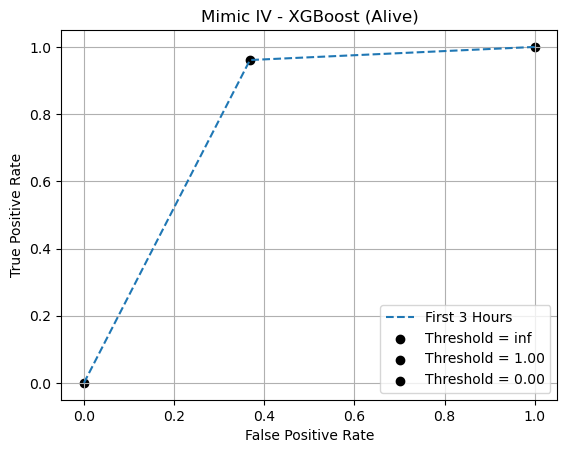

In [7]:
"""First 3 hours"""

# Your existing code for ROC curve
print("AUC = ", roc_auc_score(ground_truth_alive1, prob_alive1))
fpr1, tpr1, thresholds1 = roc_curve(ground_truth_alive1, prob_alive1)
pyplot.plot(fpr1, tpr1, linestyle='--', label='First 3 Hours')

# Scatter plot for thresholds
for i, threshold in enumerate(thresholds1):
    pyplot.scatter(fpr1[i], tpr1[i], marker='o', color='black', label=f'Threshold = {threshold:.2f}')

pyplot.xlabel(xlabel)
pyplot.ylabel(ylabel)
pyplot.legend()
pyplot.grid(True)
pyplot.title(algorithm_label + " (Alive)")

print("Thresholds          ", thresholds1)
print("False Possitive Rate", fpr1)
print("True Possitive Rate", tpr1)

# Save the plot in high resolution (adjust the dpi as needed)
plt.savefig('plots/alive_roc_3hour_plot.png', dpi=300)

# Export results to CSV
csv_file_path = 'csv/plot_results/alive_roc_3hours_results.csv'
with open(csv_file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['AUC', 'Threshold', 'False Positive Rate', 'True Positive Rate'])
    writer.writerow([roc_auc_score(ground_truth_alive1, prob_alive1), '', '', ''])  # Empty row for AUC
    for i, threshold in enumerate(thresholds1):
        writer.writerow(['', threshold, fpr1[i], tpr1[i]])

# Show the plot
pyplot.show()

AUC =  0.8010861766816039
Thresholds           [inf 1.  0.5 0. ]
False Possitive Rate [0.         0.35820896 0.3681592  1.        ]
True Possitive Rate [0.         0.95626478 0.96335697 1.        ]


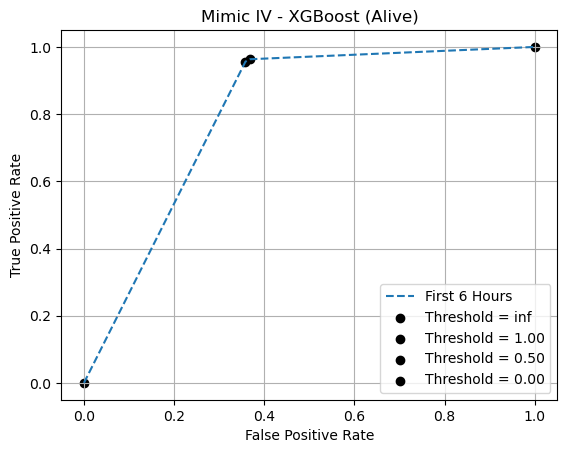

In [8]:
"""First 6 hours"""

print("AUC = ", roc_auc_score(ground_truth_alive2, prob_alive2))
fpr2, tpr2, thresholds2 = roc_curve(ground_truth_alive2, prob_alive2)
pyplot.plot(fpr2, tpr2, linestyle='--', label='First 6 Hours')

# Scatter plot for thresholds
for i, threshold in enumerate(thresholds2):
    pyplot.scatter(fpr2[i], tpr2[i], marker='o', color='black', label=f'Threshold = {threshold:.2f}')

pyplot.xlabel(xlabel)
pyplot.ylabel(ylabel)
pyplot.legend()
pyplot.grid(True)
pyplot.title(algorithm_label + " (Alive)")

print("Thresholds          ", thresholds2)
print("False Possitive Rate", fpr2)
print("True Possitive Rate", tpr2)

# Save the plot in high resolution (adjust the dpi as needed)
plt.savefig('plots/alive_roc_6hour_plot.png', dpi=300)

# Export results to CSV
csv_file_path = 'csv/plot_results/alive_roc_6hours_results.csv'
with open(csv_file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['AUC', 'Threshold', 'False Positive Rate', 'True Positive Rate'])
    writer.writerow([roc_auc_score(ground_truth_alive2, prob_alive2), '', '', ''])  # Empty row for AUC
    for i, threshold in enumerate(thresholds2):
        writer.writerow(['', threshold, fpr2[i], tpr2[i]])

# Show the plot
pyplot.show()

AUC =  0.8146619150112323
Thresholds           [ inf 1.   0.75 0.5  0.25 0.  ]
False Possitive Rate [0.         0.33333333 0.35323383 0.3681592  0.3880597  1.        ]
True Possitive Rate [0.         0.95271868 0.95744681 0.96453901 0.97163121 1.        ]


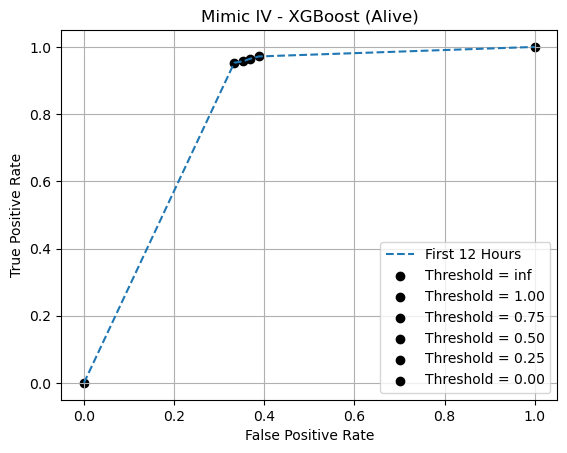

In [9]:
"""First 12 hours"""

print("AUC = ", roc_auc_score(ground_truth_alive3, prob_alive3))
fpr3, tpr3, thresholds3 = roc_curve(ground_truth_alive3, prob_alive3)
pyplot.plot(fpr3, tpr3, linestyle='--', label='First 12 Hours')

# Scatter plot for thresholds
for i, threshold in enumerate(thresholds3):
    pyplot.scatter(fpr3[i], tpr3[i], marker='o', color='black', label=f'Threshold = {threshold:.2f}')

pyplot.xlabel(xlabel)
pyplot.ylabel(ylabel)
pyplot.legend()
pyplot.grid(True)
pyplot.title(algorithm_label + " (Alive)")

print("Thresholds          ", thresholds3)
print("False Possitive Rate", fpr3)
print("True Possitive Rate", tpr3)

# Save the plot in high resolution (adjust the dpi as needed)
plt.savefig('plots/alive_roc_12hour_plot.png', dpi=300)

# Export results to CSV
csv_file_path = 'csv/plot_results/alive_roc_12hours_results.csv'
with open(csv_file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['AUC', 'Threshold', 'False Positive Rate', 'True Positive Rate'])
    writer.writerow([roc_auc_score(ground_truth_alive3, prob_alive3), '', '', ''])  # Empty row for AUC
    for i, threshold in enumerate(thresholds3):
        writer.writerow(['', threshold, fpr3[i], tpr3[i]])

# Show the plot
pyplot.show()

AUC =  0.8226568105100973
Thresholds           [  inf 1.    0.75  0.625 0.5   0.375 0.25  0.125 0.   ]
False Possitive Rate [0.         0.31840796 0.34825871 0.35820896 0.36318408 0.38308458
 0.39800995 0.42288557 1.        ]
True Possitive Rate [0.         0.94917258 0.96099291 0.96217494 0.96453901 0.96926714
 0.9751773  0.97754137 1.        ]


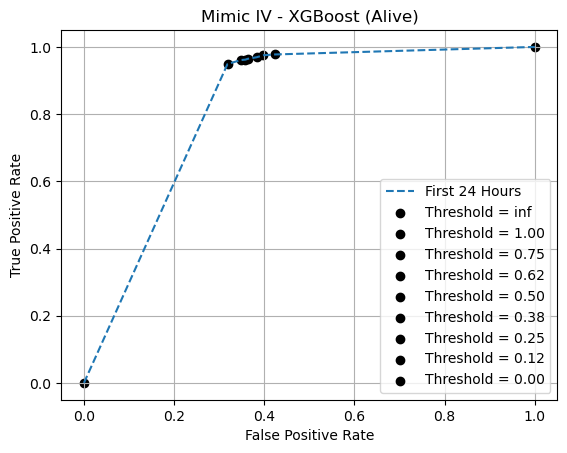

In [10]:
"""First 24 hours"""

print("AUC = ", roc_auc_score(ground_truth_alive4, prob_alive4))
fpr4, tpr4, thresholds4 = roc_curve(ground_truth_alive4, prob_alive4)
pyplot.plot(fpr4, tpr4, linestyle='--', label='First 24 Hours')

# Scatter plot for thresholds
for i, threshold in enumerate(thresholds4):
    pyplot.scatter(fpr4[i], tpr4[i], marker='o', color='black', label=f'Threshold = {threshold:.2f}')

pyplot.xlabel(xlabel)
pyplot.ylabel(ylabel)
pyplot.legend()
pyplot.grid(True)
pyplot.title(algorithm_label + " (Alive)")

print("Thresholds          ", thresholds4)
print("False Possitive Rate", fpr4)
print("True Possitive Rate", tpr4)

# Save the plot in high resolution (adjust the dpi as needed)
plt.savefig('plots/alive_roc_24hour_plot.png', dpi=300)

# Export results to CSV
csv_file_path = 'csv/plot_results/alive_roc_24hours_results.csv'
with open(csv_file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['AUC', 'Threshold', 'False Positive Rate', 'True Positive Rate'])
    writer.writerow([roc_auc_score(ground_truth_alive4, prob_alive4), '', '', ''])  # Empty row for AUC
    for i, threshold in enumerate(thresholds4):
        writer.writerow(['', threshold, fpr4[i], tpr4[i]])

# Show the plot
pyplot.show()

# Alive (consolidated charts)

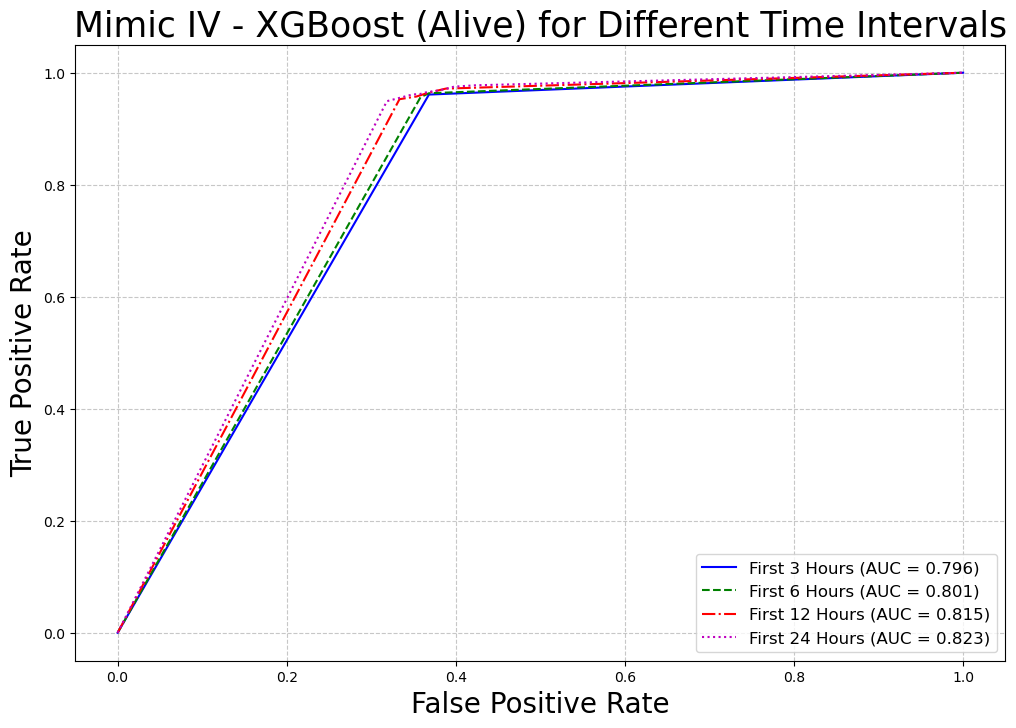

In [11]:
# Calculate AUC scores
auc_3_hours = roc_auc_score(ground_truth_alive1, prob_alive1)
auc_6_hours = roc_auc_score(ground_truth_alive2, prob_alive2)
auc_12_hours = roc_auc_score(ground_truth_alive3, prob_alive3)
auc_24_hours = roc_auc_score(ground_truth_alive4, prob_alive4)

# Create a plot
plt.figure(figsize=(12, 8))

# Plot ROC curves with different line styles and colors
plt.plot(fpr1, tpr1, linestyle='-', color='b', label=f'First 3 Hours (AUC = {auc_3_hours:.3f})')
plt.plot(fpr2, tpr2, linestyle='--', color='g', label=f'First 6 Hours (AUC = {auc_6_hours:.3f})')
plt.plot(fpr3, tpr3, linestyle='-.', color='r', label=f'First 12 Hours (AUC = {auc_12_hours:.3f})')
plt.plot(fpr4, tpr4, linestyle=':', color='m', label=f'First 24 Hours (AUC = {auc_24_hours:.3f})')

# Customize the plot
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.legend(fontsize=12, loc='best')
plt.grid(linestyle='--', alpha=0.7)
plt.title(algorithm_label + " (Alive) for Different Time Intervals", fontsize=25)

# Save the plot in high resolution (adjust the dpi as needed)
plt.savefig('plots/alive_roc_pivot_plot.png', dpi=300)

# Show the plot
plt.show()

# Death

AUC =  0.7964168519106596
Thresholds           [inf  1.  0.]
False Possitive Rate [0.         0.03900709 1.        ]
True Possitive Rate [0.        0.6318408 1.       ]


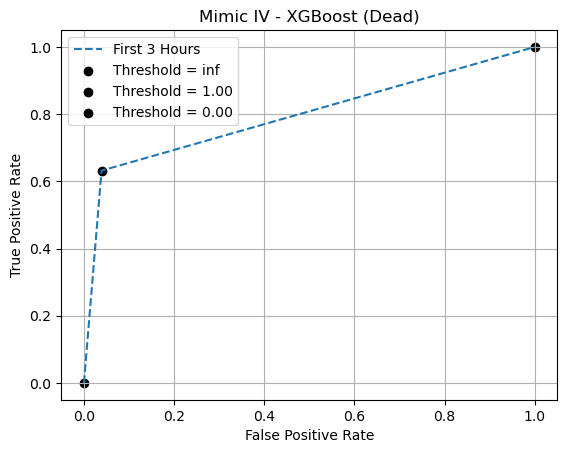

In [12]:
# Your existing code for ROC curve
print("AUC = ", roc_auc_score(ground_truth_dead1, prob_dead1))
fpr1, tpr1, thresholds1 = roc_curve(ground_truth_dead1, prob_dead1)
pyplot.plot(fpr1, tpr1, linestyle='--', label='First 3 Hours')

# Scatter plot for thresholds
for i, threshold in enumerate(thresholds1):
    pyplot.scatter(fpr1[i], tpr1[i], marker='o', color='black', label=f'Threshold = {threshold:.2f}')

pyplot.xlabel(xlabel)
pyplot.ylabel(ylabel)
pyplot.legend()
pyplot.grid(True)
pyplot.title(algorithm_label + " (Dead)")

print("Thresholds          ", thresholds1)
print("False Possitive Rate", fpr1)
print("True Possitive Rate", tpr1)

# Save the plot in high resolution (adjust the dpi as needed)
plt.savefig('plots/dead_roc_3hour_plot.png', dpi=300)

# Export results to CSV
csv_file_path = 'csv/plot_results/dead_roc_3hours_results.csv'
with open(csv_file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['AUC', 'Threshold', 'False Positive Rate', 'True Positive Rate'])
    writer.writerow([roc_auc_score(ground_truth_dead1, prob_dead1), '', '', ''])  # Empty row for AUC
    for i, threshold in enumerate(thresholds1):
        writer.writerow(['', threshold, fpr1[i], tpr1[i]])

# Show the plot
pyplot.show()

AUC =  0.8010861766816038
Thresholds           [inf 1.  0.5 0. ]
False Possitive Rate [0.         0.03664303 0.04373522 1.        ]
True Possitive Rate [0.         0.6318408  0.64179104 1.        ]


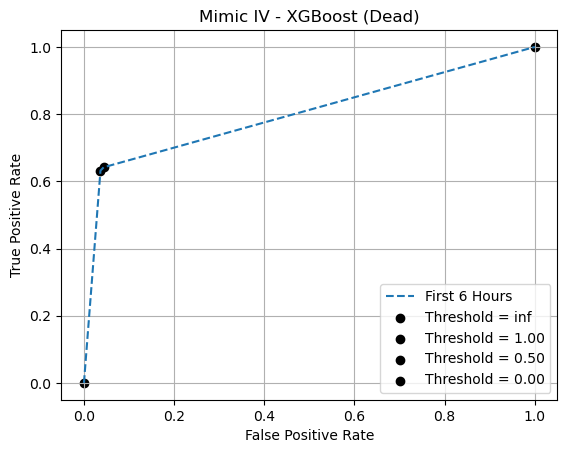

In [13]:
"""First 6 hours"""

print("AUC = ", roc_auc_score(ground_truth_dead2, prob_dead2))
fpr2, tpr2, thresholds2 = roc_curve(ground_truth_dead2, prob_dead2)
pyplot.plot(fpr2, tpr2, linestyle='--', label='First 6 Hours')

# Scatter plot for thresholds
for i, threshold in enumerate(thresholds2):
    pyplot.scatter(fpr2[i], tpr2[i], marker='o', color='black', label=f'Threshold = {threshold:.2f}')

pyplot.xlabel(xlabel)
pyplot.ylabel(ylabel)
pyplot.legend()
pyplot.grid(True)
pyplot.title(algorithm_label + " (Dead)")

print("Thresholds          ", thresholds2)
print("False Possitive Rate", fpr2)
print("True Possitive Rate", tpr2)

# Save the plot in high resolution (adjust the dpi as needed)
plt.savefig('plots/dead_roc_6hour_plot.png', dpi=300)

csv_file_path = 'csv/plot_results/dead_roc_6hours_results.csv'
with open(csv_file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['AUC', 'Threshold', 'False Positive Rate', 'True Positive Rate'])
    writer.writerow([roc_auc_score(ground_truth_dead2, prob_dead2), '', '', ''])  # Empty row for AUC
    for i, threshold in enumerate(thresholds2):
        writer.writerow(['', threshold, fpr2[i], tpr2[i]])

# Show the plot
pyplot.show()

AUC =  0.8146619150112322
Thresholds           [ inf 1.   0.75 0.5  0.25 0.  ]
False Possitive Rate [0.         0.02836879 0.03546099 0.04255319 0.04728132 1.        ]
True Possitive Rate [0.         0.6119403  0.6318408  0.64676617 0.66666667 1.        ]


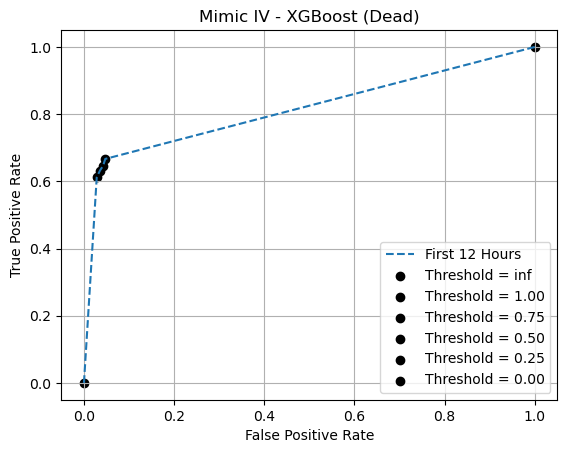

In [14]:
"""First 12 hours"""

print("AUC = ", roc_auc_score(ground_truth_dead3, prob_dead3))
fpr3, tpr3, thresholds3 = roc_curve(ground_truth_dead3, prob_dead3)
pyplot.plot(fpr3, tpr3, linestyle='--', label='First 12 Hours')

# Scatter plot for thresholds
for i, threshold in enumerate(thresholds3):
    pyplot.scatter(fpr3[i], tpr3[i], marker='o', color='black', label=f'Threshold = {threshold:.2f}')

pyplot.xlabel(xlabel)
pyplot.ylabel(ylabel)
pyplot.legend()
pyplot.grid(True)
pyplot.title(algorithm_label + " (Dead)")

print("Thresholds          ", thresholds3)
print("False Possitive Rate", fpr3)
print("True Possitive Rate", tpr3)

# Save the plot in high resolution (adjust the dpi as needed)
plt.savefig('plots/dead_roc_12hour_plot.png', dpi=300)

csv_file_path = 'csv/plot_results/dead_roc_12hours_results.csv'
with open(csv_file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['AUC', 'Threshold', 'False Positive Rate', 'True Positive Rate'])
    writer.writerow([roc_auc_score(ground_truth_dead3, prob_dead3), '', '', ''])  # Empty row for AUC
    for i, threshold in enumerate(thresholds3):
        writer.writerow(['', threshold, fpr3[i], tpr3[i]])

# Show the plot
pyplot.show()

AUC =  0.8226568105100973
Thresholds           [  inf 1.    0.875 0.75  0.625 0.5   0.375 0.125 0.   ]
False Possitive Rate [0.         0.02245863 0.0248227  0.03073286 0.03546099 0.03782506
 0.03900709 0.05082742 1.        ]
True Possitive Rate [0.         0.57711443 0.60199005 0.61691542 0.63681592 0.64179104
 0.65174129 0.68159204 1.        ]


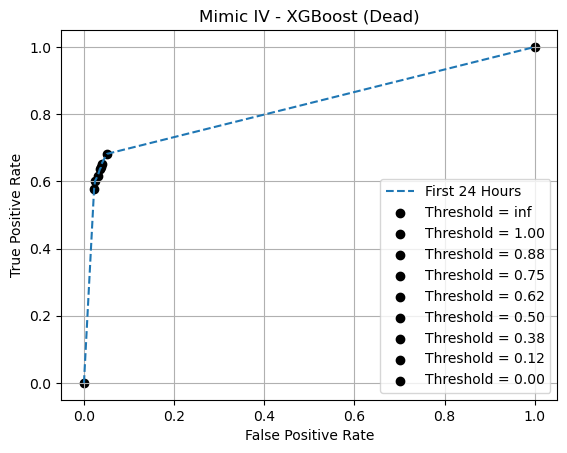

In [15]:
"""First 24 hours"""

print("AUC = ", roc_auc_score(ground_truth_dead4, prob_dead4))
fpr4, tpr4, thresholds4 = roc_curve(ground_truth_dead4, prob_dead4)
pyplot.plot(fpr4, tpr4, linestyle='--', label='First 24 Hours')

# Scatter plot for thresholds
for i, threshold in enumerate(thresholds4):
    pyplot.scatter(fpr4[i], tpr4[i], marker='o', color='black', label=f'Threshold = {threshold:.2f}')

pyplot.xlabel(xlabel)
pyplot.ylabel(ylabel)
pyplot.legend()
pyplot.grid(True)
pyplot.title(algorithm_label + " (Dead)")

print("Thresholds          ", thresholds4)
print("False Possitive Rate", fpr4)
print("True Possitive Rate", tpr4)

# Save the plot in high resolution (adjust the dpi as needed)
plt.savefig('plots/dead_roc_24hour_plot.png', dpi=300)

csv_file_path = 'csv/plot_results/dead_roc_24hours_results.csv'
with open(csv_file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['AUC', 'Threshold', 'False Positive Rate', 'True Positive Rate'])
    writer.writerow([roc_auc_score(ground_truth_dead4, prob_dead4), '', '', ''])  # Empty row for AUC
    for i, threshold in enumerate(thresholds4):
        writer.writerow(['', threshold, fpr4[i], tpr4[i]])

# Show the plot
pyplot.show()

# Dead (consolidated charts)

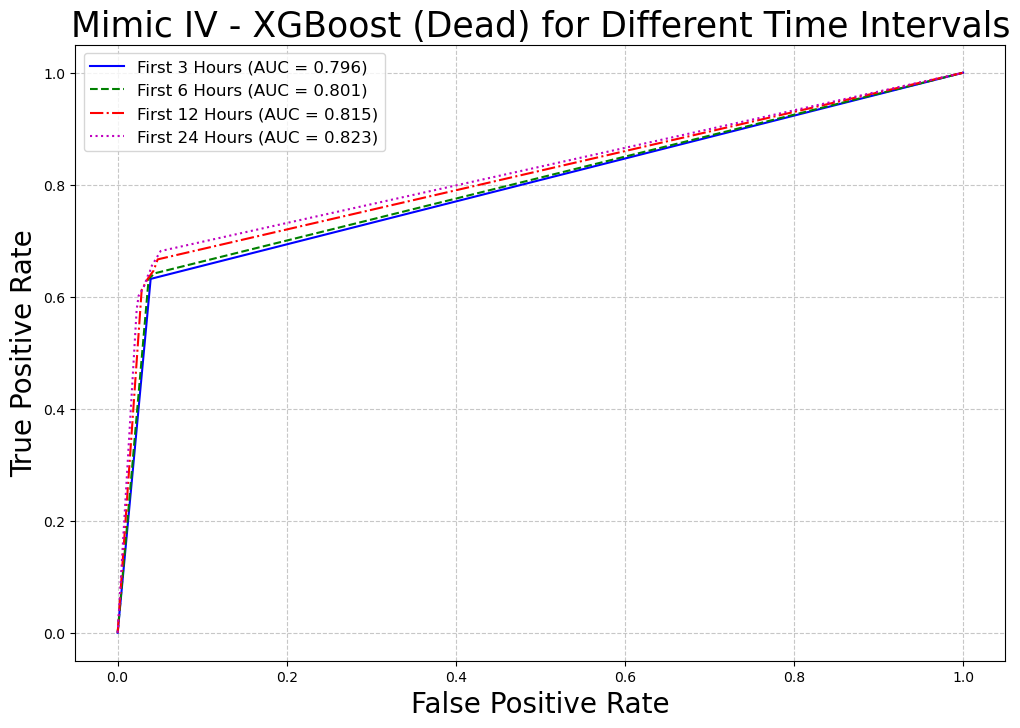

In [16]:
# Calculate AUC scores
auc_3_hours = roc_auc_score(ground_truth_dead1, prob_dead1)
auc_6_hours = roc_auc_score(ground_truth_dead2, prob_dead2)
auc_12_hours = roc_auc_score(ground_truth_dead3, prob_dead3)
auc_24_hours = roc_auc_score(ground_truth_dead4, prob_dead4)

# Create a plot
plt.figure(figsize=(12, 8))

# Plot ROC curves with different line styles and colors
plt.plot(fpr1, tpr1, linestyle='-', color='b', label=f'First 3 Hours (AUC = {auc_3_hours:.3f})')
plt.plot(fpr2, tpr2, linestyle='--', color='g', label=f'First 6 Hours (AUC = {auc_6_hours:.3f})')
plt.plot(fpr3, tpr3, linestyle='-.', color='r', label=f'First 12 Hours (AUC = {auc_12_hours:.3f})')
plt.plot(fpr4, tpr4, linestyle=':', color='m', label=f'First 24 Hours (AUC = {auc_24_hours:.3f})')

# Customize the plot
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.legend(fontsize=12, loc='best')
plt.grid(linestyle='--', alpha=0.7)
plt.title(algorithm_label + " (Dead) for Different Time Intervals", fontsize=25)

# Save the plot in high resolution (adjust the dpi as needed)
plt.savefig('plots/dead_roc_pivot_plot.png', dpi=300)

# Show the plot
plt.show()